# Fluent Python
https://github.com/fluentpython/example-code

파이썬 용어집 

https://docs.python.org/ko/3/glossary.html

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np


## CHAPTER 16. Coroutines

일반적으로 yield 문이 표현식의 오른쪽에 나오거나, 값을 생성하지 않는 경우도 있다. yield 키워드 뒤에 표현식이 없으면 제너레이터는 None 을 생성한다. 호출자가 next() 대신 값을 전송하는 send() 를 호출하면 코루팅이 호출자로부터 데이터를 받을 수 있다. 일반적으로 호출자가 코루틴에 값을 밀어 넣는다. 

yield 키워드를 통해 아무런 데이터도 주고 받지 않을 수 있다. 데이터 흐름에 무관하게 yield 는 실행을 제어하는 장치로서 멀티태스킹에서의 협업을 구현하기 위해 사용 할 수 있다. 즉 각 코루팅이 중앙의 스케쥴러에 제어를 양보에서 다른 코루틴이 실행될 게 할수 있다. 

### How Coroutines Evolved from Generators

(코루틴: 두개의 독립된 객체가 실행을 주고 받음 [참고](https://haerakai.tistory.com/36))

제너레이터의 호출자는 send() 를 이용해서 제너레이터 함수 내부의 yield 표현식의 값이 될 데이터를 전송.
이렇게 제너레이터가 호출자에 데이터를 생성해주고 호출자로부터 데이터를 받으면서 호출자와 협업하는 프로시저인 코루틴이 됨



### Basic Behavior of a Generator Used as a Coroutine

A coroutine can be in one of four states.
- 'GEN_CREATED'
Waiting to start execution.
- 'GEN_RUNNING'
Currently being executed by the interpreter.1
- 'GEN_SUSPENDED'
Currently suspended at a yield expression.
- 'GEN_CLOSED'
Execution has completed.


코루틴이 호출자로 부터 값을 받을 수 있도록 처음 나오는 yield 문까지 실행을 진행 


In [1]:
def simple_coro2(a):
    print('-> Started: a =', a)
    b = yield a
    print('-> Received: b =', b)
    c = yield a + b
    print('-> Received: c =', c)

In [2]:
my_coro2 = simple_coro2(14)
from inspect import getgeneratorstate
getgeneratorstate(my_coro2)

'GEN_CREATED'

In [3]:
next(my_coro2)

-> Started: a = 14


14

In [4]:
getgeneratorstate(my_coro2)

'GEN_SUSPENDED'

In [5]:
my_coro2.send(28)

-> Received: b = 28


42

In [6]:
my_coro2.send(99)

-> Received: c = 99


StopIteration: 

In [7]:
getgeneratorstate(my_coro2)

'GEN_CLOSED'

simple_core2 실행단계
1. next(my_core2) 첫번쨰 메시지를 출력하고 yield a 까지 실행되어 숫자 14를 생성
2. my_core2.send(28) 은 28 을 b 에 할당하고 두번쨰 메시지를 출력하고, yield a + b 까지 실행되어 숫자 42 를 반환
3. my_core2.send(99) 는 99 를 c 에 할당하고 세번쨰 메시지를 출력하고, 코루팅을 끝까지 실행

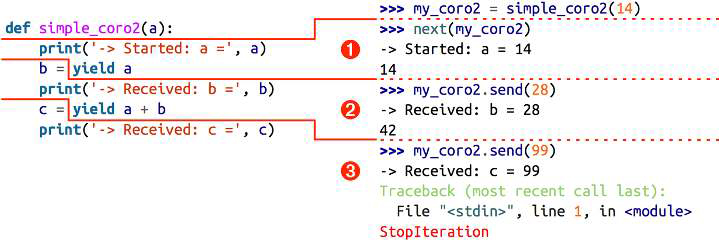

### Decorators for Coroutine Priming

my_core.send(x) 를 호출하기 전에 next(my_core) 를 반드시 호출해야한다. 

@coroutine

In [9]:
from functools import wraps

def coroutine(func):
    """Decorator: primes `func` by advancing to first `yield`"""
    @wraps(func)
    def primer(*args,**kwargs):
        gen = func(*args,**kwargs)
        next(gen)
        return gen
    return primer

yield from 구문은 자동으로 자신을 실행한 코루틴을 가동시키므로, @coroutine 데커레이터와 함께 사용 할수 없다. 

파이썬 3.4 표준 라이브러리에서 제공하는 @asyncio.coroutine 데코레이터는 yield from 과 함꼐 사용 할수 있게 설계되어 있다. 



### Coroutine Termination and Exception Handling

코루틴 안에서 발생한 예외를 처리하지 않으면, next() 나 send() 로 코루틴을 호출한 호출자에 예외가 전파된다. 

코루틴 안에서 예외처리를 하지 않으면, 예외가 발생 시, 코루틴이 종료되고 이후에 코루틴을 다시 활성화 하려면 StopIteration 예외가 발생한다. 

예외를 전달 할 수 있도록 두 함수를 제공한다. 

**generator.throw(exc_type[, exc_value[, traceback]])**
제너레이터가 중단한 곳의 yield 표현식에 예외를 전달. 제너레이터가 예외를 처리하면, 제어흐름이 다음 yield 문까지 진행하고, 생성된 값은 generator.throw() 호출 값이 된다. 제너레이터가 예외를 처리 하지 않으면 호출자까지 예외가 전파된다. 

**generator.close()**
제너레이터가 실행을 중단한 yield 표현식이 GeneratorExit 예외를 발생시키게 만든다. 제너레이터가 예외를 처리 하지 않거나 StopIterator 예외 발생시, 아무 에러도 호출자에 전달되지 않는다. GeneratorExit 예외를 바등면 제너레이터는 아무런 값도 생성하지 않아야 한다. 아니면 RuntimeError 예외가 발생. 다른 모든 예외는 호출자에게 전달된다. 



In [10]:
class DemoException(Exception):
    """An exception type for the demonstration."""

def demo_exc_handling():
    print('-> coroutine started')
    while True:
        try:
            x = yield
        except DemoException:
            print('*** DemoException handled. Continuing...')
        else:
            print('-> coroutine received: {!r}'.format(x))
    raise RuntimeError('This line should never run.')

In [11]:
exc_coro = demo_exc_handling()
next(exc_coro)
exc_coro.send(11)

-> coroutine started
-> coroutine received: 11


In [12]:
exc_coro.throw(DemoException)

*** DemoException handled. Continuing...


In [13]:
from inspect import getgeneratorstate
getgeneratorstate(exc_coro)

'GEN_SUSPENDED'

In [14]:
exc_coro.close()

In [15]:
getgeneratorstate(exc_coro)

'GEN_CLOSED'

마지막 행은 도달 할 수 없다. 위에 나온 무한 루프는 처리 되지 않은 예외에 의해서만 중된될 수 있으며, 예외를 처리 하지 않으면 코루틴의 실행이 바로 중단된다. 

코루틴이 어떻게 종료되든 어떤 정리 코드를 실행해야 하는 경우에는 try/finally 블록안에 코루틴의 해당 코드를 넣어야 한다. 

In [17]:
class DemoException(Exception):
    """An exception type for the demonstration."""

def demo_finally():
    print('-> coroutine started')
    try:
        while True:
            try:
                x = yield
            except DemoException:
                print('*** DemoException handled. Continuing...')
            else:
                print('-> coroutine received: {!r}'.format(x))
    finally:
        print('-> coroutine ending')

### Returning a Value from a Coroutine

In [18]:
from collections import namedtuple

Result = namedtuple('Result', 'count average')

def averager():
    total = 0.0
    count = 0
    average = None
    while True:
        term = yield
        if term is None:
            break
        total += term
        count += 1
        average = total/count
    return Result(count, average)

In [19]:
coro_avg = averager()
next(coro_avg)

In [21]:
coro_avg.send(10)
coro_avg.send(6.5)
coro_avg.send(None)

StopIteration: Result(count=3, average=8.833333333333334)

None 보내면 루프를 빠져나오고 코루틴이 결과를 반환하면서 종료하게 된다. StopIteration 예외 객체의value 속성에 반환값이 들어 있다. 

In [22]:
coro_avg = averager()
next(coro_avg)
coro_avg.send(10)
coro_avg.send(6.5)

In [23]:
try:
    coro_avg.send(None)
except StopIteration as exc:
    result = exc.value

result

Result(count=2, average=8.25)

### Using yield from

generator gen() 이 yield from subgen() 를 호출하고, subgen() 이 이어받아 값을 생성하고 get()의 호출자에 반환한다. 

subgen() 이 직접 호출자를 이끄는 동안 gen() 은 subgen() 이 종료될떄까지 실행을 중단한다. 



In [2]:
def gen():
    yield from 'AB'
    yield from range(1, 3)

list(gen())

['A', 'B', 1, 2]

In [5]:
def chain(*iterables):
    for it in iterables:
        yield from it

In [8]:
s = 'ABC'
t = tuple(range(3))

list(chain(s, t))

['A', 'B', 'C', 0, 1, 2]

yield from 표현식이 x 객체에 대해 첫번째로 하는 일은 iter(x) 를 호출해서 x 의 반복자를 가져오는 것이다. 

이 모든 반복형이 x 에 사용될 수 있다.

yield from 의 주요한 특징은 가장 바깥쪽 호출자와 가장 안쪽에 있는 하위 제너레이터 사이 양방향 채널을 열어준다는 것이다. 

**coroutine delegation** : 중간에 있는 코루틴이 판에 박힌 듯한 예외 처리 코드를 구현할 필요 없이 예외를 직접 던질 수 있다. 

* delegationg generator : yield from <반복형> 표현식을 담고 있는 제너레이터 함수 
* subgenerator : yield from 표혁식 중 <반복형> 에서 가져오는 제너레이터
* caller : 대표 제너레이터를 호출하는 코드 

delegationg generator 가 yield from 에서 중단하고 있는 동안, caller 는 subgenerator 에 데이터를 직접 전송하고, subgenerator 는 다시 데이터를 생성해서 caller 에 전달한다. subgenerator 가 생행을 완료하고 인터프리터가 반환된값을 첨부한 StopIteration 을 발생시키면 delegationg generator 가 실행을 재개한다. 

In [11]:
from collections import namedtuple

Result = namedtuple('Result', 'count average')

# the subgenerator
def averager():
    total = 0.0
    count = 0
    average = None
    while True:
        term = yield     # 클라이언트가 전송하는 값이 term 변수에 바인딩됨
        if term is None: # 종료 조건. 이 조건이 없으면 코루틴을 호출하는 yield from 영원히 중단됨
            break
        total += term
        count += 1
        average = total/count
    return Result(count, average)  # grouper() 의 yield from 표현식의 값이 됨

# the delegating generator
def grouper(results, key):  
    while True: # averager() 객체는 하나의 코루틴으로 작동
        results[key] = yield from averager()
        # grouper() 가 값을 받을 때마다 yield from 에 의해 average 객체로 전달. 
        # grouper 는 클라이언트가 전송한 값들을 average 객체가 소진할 떄까지 중단됨.
        # 반환값을 results[key] 에 바인딩 후 다시 while 문을 돌아 yield from 에서 멈춤 
    
# the client code, a.k.a. the caller
def main(data):
    results = {}
    for key, values in data.items():
        # group 은 결과를 저장할 results 딕셔너리와 key 로 grouper 를 호출해서 반환된 제너레이터 객체
        group = grouper(results, key) 
        next(group) # 코루틴 가동
        for value in values:
            group.send(value)  # 값을 하나씩 grouper 에 전달. 이 값은 average 의 term 문장의 yield. grouper 는 값을 볼수 없음 
        group.send(None) # important!
        # None 을 grouper 에 전달하면 현재 averager 객체가 종료하고 grouper 가 실행을 재개하게 만듬 
        # grouper 는 또 다른 average 객체를 생성해서 다음 값을 받음 
  
    # print(results) # uncomment to debug
    report(results)

# output report
def report(results):
    for key, result in sorted(results.items()):
        group, unit = key.split(';')
        print('{:2} {:5} averaging {:.2f}{}'.format(result.count, group, result.average, unit))

data = {
'girls;kg':
[40.9, 38.5, 44.3, 42.2, 45.2, 41.7, 44.5, 38.0, 40.6, 44.5],
'girls;m':
[1.6, 1.51, 1.4, 1.3, 1.41, 1.39, 1.33, 1.46, 1.45, 1.43],
'boys;kg':
[39.0, 40.8, 43.2, 40.8, 43.1, 38.6, 41.4, 40.6, 36.3],
'boys;m':
[1.38, 1.5, 1.32, 1.25, 1.37, 1.48, 1.25, 1.49, 1.46],
}

In [10]:
main(data)

 9 boys  averaging 40.42kg
 9 boys  averaging 1.39m
10 girls averaging 42.04kg
10 girls averaging 1.43m


### The Meaning of yield from

yield from 동작 
* 하위 제너레이터가 생성하는 값은 모두 대표 제너레이터의 호출자(클라이언트) 에 바로 전달된다. 
* send() 를 통해 대표 제너레이터에 전달한 값은 모두 하위 제너레이터에 직접 전달된다. 값이 None 이 면 하위 제너레이터의 \_\_next\_\_() 메서드가 호출된다. 전달된 값이 None 이 아니면 하위 제너레이터의 send() 메서드가 호출된다. 호출된 메서드에서 StopIteration 예외가 발생하면 대표 제너레이터의 실행이 재개된다. 그외의 예외는 대표 제너레이터에 전달된다. 
* 제너레이터나 하위 제너레이터에서 return expr 문을 실행하면, 제너레이터를 빠져나온 후 StopIteration(expr) 예외가 발생한다. 
* 하위제너레이터가 실행을 마친 후 발생한 StopIteration 예외의 첫번째 인수가 yield from 표현식의 값이 된다. 

예외와 종료에 관한 특징
* 대표 제너레이터에 던져진 GeneratorExit 이외의 예외는 하위 제너레이터의 throw() 메서드에 전달된다. throw() 메서드를 호출해서 StopIteration 예외가 발생하면 대표 제너레이터의 실행이 재개된다. 그 외의 예외는 대표 제너레이터에 전달된다. 
* GeneratorExit 예외가 대표 제너레이터에 던져지거나 대표 제너레이터의 close() 메서드가 호출되면 하위 제너레이터의 close() 메서드가 호출된다. 그 결과 예외가 발생하면 발생한 예외가 대표 제너레이터에 전파된다. 그렇지 않으면 대표 제너레이터에서 GeneratorExit 예외가 발생한다. 

